In [1]:
!nvidia-smi

Sun Jul 16 19:04:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |  10942MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [15]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import (
    alexnet, AlexNet_Weights, resnet18, ResNet18_Weights, resnet50, ResNet50_Weights,
    efficientnet_b0, EfficientNet_B0_Weights, 
    efficientnet_b1, EfficientNet_B1_Weights, 
    efficientnet_b2, EfficientNet_B2_Weights, 
    efficientnet_b3, EfficientNet_B3_Weights, 
    efficientnet_b4, EfficientNet_B4_Weights, 
)
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')

In [129]:
import utils
reload(utils)
from utils import get_relevance
get_relevance(pca, buyer_data)

0.9999999999990676

In [111]:
from utils import compute_volumes, compute_X_tilde_and_counts, compute_robust_volumes, get_volume, get_relevance

In [17]:
root = Path('../data/')
download = True

mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion = FashionMNIST(root=root, train=False, download=download)
emnist = EMNIST(root=root, split='byclass', train=False, download=download)

In [18]:
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).cuda()

model.eval();

upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)

embed = lambda loader: torch.cat([model(x.cuda()).detach().cpu() for x in iter(loader)])

batch_size = 16
mnist_buyer_loader = torch.utils.data.DataLoader(upsample(mnist_buyer.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
mnist_buyer_features = embed(mnist_buyer_loader)

mnist_seller_loader = torch.utils.data.DataLoader(upsample(mnist_seller.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
mnist_seller_features = embed(mnist_seller_loader)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/luchar/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 23.7MB/s]


In [250]:
buyer_data = mnist_buyer_features[
    # (mnist_buyer.targets == 1)
    ( mnist_buyer.targets == 2)
    | (mnist_buyer.targets == 3) 
    | (mnist_buyer.targets == 4)
    | (mnist_buyer.targets == 5) 
    # | (mnist_buyer.targets == 6)
]
buyer_data -= buyer_data.mean(0)
buyer_cov = np.cov(buyer_data.T)

In [256]:
n = 10000

seller_1_data = mnist_seller_features[
    # (mnist_seller.targets == 1) 
    (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_2_data = mnist_seller_features[
    # (mnist_seller.targets == 1) 
    (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_3_data = mnist_seller_features[
    # (mnist_seller.targets == 1) 
    (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_4_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_5_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_6_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_7_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_8_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    | (mnist_seller.targets == 0)
][:n]

seller_1_data -= seller_1_data.mean(0)
seller_2_data -= seller_2_data.mean(0)
seller_3_data -= seller_3_data.mean(0)
seller_4_data -= seller_4_data.mean(0)
seller_5_data -= seller_5_data.mean(0)
seller_6_data -= seller_6_data.mean(0)
seller_7_data -= seller_7_data.mean(0)
seller_8_data -= seller_8_data.mean(0)

seller_1_cov = np.cov(seller_1_data.T)
seller_2_cov = np.cov(seller_2_data.T)
seller_3_cov = np.cov(seller_3_data.T)
seller_4_cov = np.cov(seller_4_data.T)
seller_5_cov = np.cov(seller_5_data.T)
seller_6_cov = np.cov(seller_6_data.T)
seller_7_cov = np.cov(seller_7_data.T)
seller_8_cov = np.cov(seller_8_data.T)

In [257]:
# pca = PCA(n_components=5, svd_solver='randomized', whiten=True)
pca = PCA(n_components=30, svd_solver='randomized', whiten=False)
pca.fit(buyer_data)
pca.explained_variance_

array([70.20943729, 29.70330184, 17.36661482,  8.15241262,  5.7698312 ,
        4.89608125,  4.58596238,  3.49441896,  3.21605067,  2.8105524 ,
        2.49714467,  1.73985936,  1.59043291,  1.33989763,  1.09885954,
        1.04873458,  0.91958068,  0.77106087,  0.70935003,  0.63620682,
        0.55329562,  0.51218851,  0.48807784,  0.48140638,  0.42148511,
        0.39077227,  0.37025164,  0.3439625 ,  0.32563121,  0.30843692])

In [258]:
reload(utils)
def get_value(pca, seller):
    rel = utils.get_relevance(pca, seller)
    vol = utils.get_volume(np.cov(pca.transform(seller).T))
    return rel, vol

In [261]:
import matplotlib
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, 8).astype(int)]

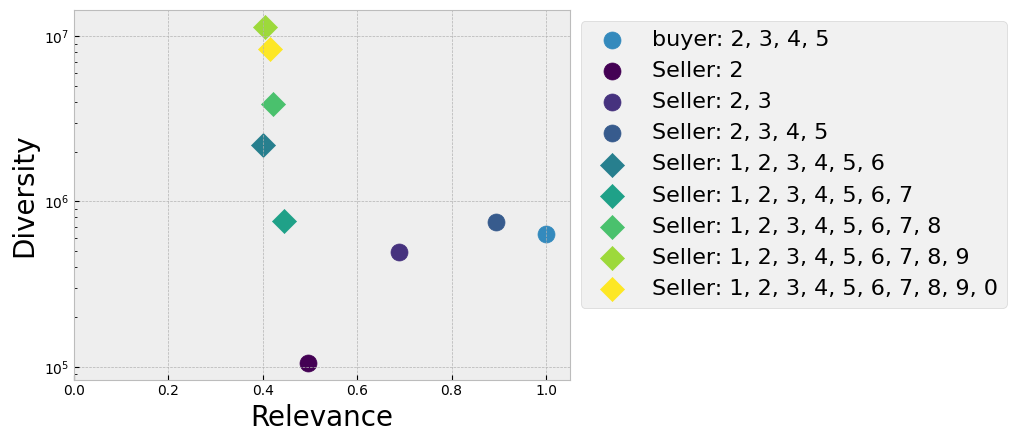

In [267]:
s = 150
plt.scatter(*get_value(pca, buyer_data), label='buyer: 2, 3, 4, 5', s=s, marker='o')
plt.scatter(*get_value(pca, seller_1_data), color=colors[0], s=s, marker='o', label='Seller: 2')
plt.scatter(*get_value(pca, seller_2_data), color=colors[1], s=s, marker='o', label='Seller: 2, 3')
plt.scatter(*get_value(pca, seller_3_data), color=colors[2], s=s, marker='o', label='Seller: 2, 3, 4, 5')
plt.scatter(*get_value(pca, seller_4_data), color=colors[3], s=s, marker='D', label='Seller: 1, 2, 3, 4, 5, 6')
plt.scatter(*get_value(pca, seller_5_data), color=colors[4], s=s, marker='D', label='Seller: 1, 2, 3, 4, 5, 6, 7')
plt.scatter(*get_value(pca, seller_6_data), color=colors[5], s=s, marker='D', label='Seller: 1, 2, 3, 4, 5, 6, 7, 8')
plt.scatter(*get_value(pca, seller_7_data), color=colors[6], s=s, marker='D', label='Seller: 1, 2, 3, 4, 5, 6, 7, 8, 9')
plt.scatter(*get_value(pca, seller_8_data), color=colors[7], s=s, marker='D', label='Seller: 1, 2, 3, 4, 5, 6, 7, 8, 9, 0')
# plt.scatter(*get_value(pca, seller_9_data), color=colors[8], s=s, marker='^', label='1, 2, 3, 4, 5, 6, 7, 8, 9')
# plt.scatter(*get_value(pca, seller_10_data),color=colors[9], s=s, marker='^', label='1, 2, 3, 4, 5, 6, 7, 8, 9, 0')
plt.yscale('log')
plt.xlim(0.0, 1.05)
plt.xlabel('Relevance', fontsize=20)
plt.ylabel('Diversity', fontsize=20)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
plt.savefig(f'mnist-diversity.png', bbox_inches='tight')

In [ ]:
# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = True

X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

In [102]:
(np.cov(
    (
        mnist_buyer_features[
            # (mnist_buyer.targets == 1)
            ( mnist_buyer.targets == 2)
            | (mnist_buyer.targets == 3) 
            | (mnist_buyer.targets == 4)
            | (mnist_buyer.targets == 5) 
            # | (mnist_buyer.targets == 6)
        ][:100]
        - mnist_buyer_features[
            # (mnist_buyer.targets == 1)
            ( mnist_buyer.targets == 2)
            | (mnist_buyer.targets == 3) 
            | (mnist_buyer.targets == 4)
            | (mnist_buyer.targets == 5) 
            # | (mnist_buyer.targets == 6)
        ][:100].mean(0)
    ).T
) @ eig_vec[:, :5]).real

array([[ 0.42073469, -0.604131  , -0.46812137, -0.09070648, -0.08075475],
       [ 1.25021687, -0.17979735, -0.43780573,  0.06698081,  0.19572634],
       [-2.25650782, -0.56598033,  0.29584861, -0.19486821,  0.26914364],
       ...,
       [ 1.33098763, -0.75450409, -0.43891952, -0.12299085, -0.188784  ],
       [ 0.27218723,  0.2933185 ,  0.28706455, -0.16328166, -0.19196848],
       [-1.16878095, -3.81004668,  0.0538549 , -0.14150643,  0.06117587]])

In [80]:
eig_val, eig_vec = np.linalg.eig(
    np.cov(
        (
            mnist_buyer_features[
                # (mnist_buyer.targets == 1)
                ( mnist_buyer.targets == 2)
                | (mnist_buyer.targets == 3) 
                | (mnist_buyer.targets == 4)
                | (mnist_buyer.targets == 5) 
                # | (mnist_buyer.targets == 6)
            ][:100]
            - mnist_buyer_features[
                # (mnist_buyer.targets == 1)
                ( mnist_buyer.targets == 2)
                | (mnist_buyer.targets == 3) 
                | (mnist_buyer.targets == 4)
                | (mnist_buyer.targets == 5) 
                # | (mnist_buyer.targets == 6)
            ][:100].mean(0)
        ).T
    )
)

In [68]:
# plt.imshow(eig_vec @ eig_vec.T)

In [84]:
pca.explained_variance_

array([69.35879993, 35.9183598 , 14.00217319, 10.55732806,  6.26711425])

In [62]:
mnist_buyer_features.shape

torch.Size([10000, 1000])

In [63]:

    np.cov((mnist_buyer_features[
        # (mnist_buyer.targets == 1)
        ( mnist_buyer.targets == 2)
        | (mnist_buyer.targets == 3) 
        | (mnist_buyer.targets == 4)
        | (mnist_buyer.targets == 5) 
        # | (mnist_buyer.targets == 6)
    ][:100]
           - mnist_buyer_features[
               # (mnist_buyer.targets == 1)
               ( mnist_buyer.targets == 2)
               | (mnist_buyer.targets == 3) 
               | (mnist_buyer.targets == 4)
               | (mnist_buyer.targets == 5) 
               # | (mnist_buyer.targets == 6)
           ][:100].mean(0)
          ).T).shape

(1000, 1000)

In [117]:
from importlib import reload
import utils
reload(utils)
from utils import get_relevance
get_relevance(pca, 
              np.cov(
                  (mnist_buyer_features[
                      # (mnist_buyer.targets == 1)
                      ( mnist_buyer.targets == 2)
                      | (mnist_buyer.targets == 3) 
                      | (mnist_buyer.targets == 4)
                      | (mnist_buyer.targets == 5) 
                      # | (mnist_buyer.targets == 6)
                  ][:1000]
                   - mnist_buyer_features[
                       # (mnist_buyer.targets == 1)
                       ( mnist_buyer.targets == 2)
                       | (mnist_buyer.targets == 3) 
                       | (mnist_buyer.targets == 4)
                       | (mnist_buyer.targets == 5) 
                       # | (mnist_buyer.targets == 6)
                   ][:1000].mean(0)
                  ).T
              )
             )

0.8641774340517324

In [25]:
n = 10000

vol_b = get_volume(pca.transform(np.cov(mnist_buyer_features[
    ( mnist_buyer.targets == 2)
    | (mnist_buyer.targets == 3) 
    | (mnist_buyer.targets == 4)
    | (mnist_buyer.targets == 5) 
][:n].T)))
print(f'{vol_b:,.0f}')

vol_s1 = get_volume(pca.transform(np.cov(mnist_seller_features[
    # (mnist_seller.targets == 1) 
    # | (mnist_seller.targets == 2)
    (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s1:,.0f}')

vol_s2 = get_volume(pca.transform(np.cov(mnist_seller_features[
    # (mnist_seller.targets == 1) 
    # | (mnist_seller.targets == 2)
    (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s2:,.0f}')

vol_s3 = get_volume(pca.transform(np.cov(mnist_seller_features[
    # (mnist_seller.targets == 1) 
    (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s3:,.0f}')

vol_s4 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s4:,.0f}')


vol_s5 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s5:,.0f}')

vol_s6 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s6:,.0f}')

vol_s7 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s7:,.0f}')

vol_s8 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s8:,.0f}')

vol_s9 = get_volume(pca.transform(
    np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s9:,.0f}')

166,553
166,553
166,553
166,553
166,553
166,553
166,553
166,553
166,553
166,553


In [9]:

# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = True

X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

tensor([7, 2, 1,  ..., 4, 5, 6])

In [ ]:

batch_size = 64
buyer_loader = torch.utils.data.DataLoader(upsample(buyer_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_loaders = {
    seller: torch.utils.data.DataLoader(upsample(seller_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
    for seller, seller_data in seller_data.items()
}
# seller2_loader = torch.utils.data.DataLoader(upsample(seller2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller3_loader = torch.utils.data.DataLoader(upsample(seller3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller4_loader = torch.utils.data.DataLoader(upsample(seller4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller5_loader = torch.utils.data.DataLoader(upsample(seller5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller6_loader = torch.utils.data.DataLoader(upsample(seller6_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller7_loader = torch.utils.data.DataLoader(upsample(seller7_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller8_loader = torch.utils.data.DataLoader(upsample(seller8_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller9_loader = torch.utils.data.DataLoader(upsample(seller9_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller10_loader = torch.utils.data.DataLoader(upsample(seller10_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller11_loader = torch.utils.data.DataLoader(upsample(seller11_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller12_loader = torch.utils.data.DataLoader(upsample(seller12_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller13_loader = torch.utils.data.DataLoader(upsample(seller13_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

# seller_fashion_loader = torch.utils.data.DataLoader(upsample(seller_fashion_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_emnist_loader = torch.utils.data.DataLoader(upsample(seller_emnist_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller_cifar_loader = torch.utils.data.DataLoader(upsample(seller_cifar_data.moveaxis(-1, 1)), batch_size=batch_size)


buyer_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(buyer_loader)])

seller_features = {
    seller: torch.cat([model(x.cuda()).detach().cpu() for x in iter(loader)])
    for seller, loader in seller_loaders.items()
}
    

# seller_fashion_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_fashion_loader)])
seller_emnist_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_emnist_loader)])
# seller_cifar_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_cifar_loader)])

torch.cuda.empty_cache()

In [4]:
def subset(dataset, classes):
    class_mask = {k: np.array(dataset.targets) == v for k, v in dataset.class_to_idx.items()}
    dummy = np.array([False] * len(dataset))
    for c in classes:
        dummy ^= class_mask[c]
    return dummy

In [4]:
# buyer_index = subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
# buyer_index = subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
buyer_index = subset(mnist_buyer, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
seller1_index = subset(mnist_seller, ('0 - zero',))
seller2_index = subset(mnist_seller, ('0 - zero', '1 - one'))
seller3_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two'))
seller4_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three'))
seller5_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
seller6_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))
seller7_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))
seller8_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))
seller9_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))
seller10_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))

seller_indexes = {
    'MNIST: 0': seller1_index,
    'MNIST: 0, 1': seller2_index,
    'MNIST: 0, 1, 2': seller3_index,
    'MNIST: 0, 1, 2, 3': seller4_index,
    'MNIST: 0, 1, 2, 3, 4': seller5_index,
    'MNIST: 0-5': seller6_index,
    'MNIST: 0-6': seller7_index,
    'MNIST: 0-7': seller8_index,
    'MNIST: 0-8': seller9_index,
    'MNIST: 0-9': seller10_index,
}
    

# seller2_index = subset(mnist_seller, ('1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))
# seller3_index = subset(mnist_seller, ('2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))
# seller4_index = subset(mnist_seller, ('3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))
# seller5_index = subset(mnist_seller, ('4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))
# seller6_index = subset(mnist_seller, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
# seller7_index = subset(mnist_seller, ('0 - zero', ))
# seller8_index = subset(mnist_seller, ('5 - five', ))
# seller9_index = subset(mnist_seller, ('0 - zero', '5 - five'))
# seller10_index = subset(mnist_seller, ('0 - zero', '1 - one', '5 - five', '6 - six'))
# seller11_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '5 - five', '6 - six', '7 - seven'))
# seller12_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '5 - five', '6 - six', '7 - seven', '8 - eight'))
# seller13_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))

emnist_index = subset(emnist, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))


# num_samples = 100
# num_samples = 1000
buyer_samples = 10000
seller_samples = 10000

buyer_data = (mnist_buyer.data[buyer_index] / 255) [:buyer_samples]
seller_data = {
    seller: (mnist_seller.data[index] / 255) [:seller_samples]
    for seller, index in seller_indexes.items()
}

# seller_fashion_data = (fashion.data / 255) [:seller_samples]
# seller_cifar_data = torch.tensor(cifar.data / 255, dtype=torch.float) [:seller_samples]
seller_emnist_data = (emnist.data[emnist_index] / 255) [:seller_samples]

# buyer_data_flat = buyer_data.reshape(-1, 28*28) 
# seller1_data_flat = seller1_data.reshape(-1, 28*28) 
# seller2_data_flat = seller2_data.reshape(-1, 28*28) 
# seller3_data_flat = seller3_data.reshape(-1, 28*28) 
# seller4_data_flat = seller4_data.reshape(-1, 28*28) 
# seller5_data_flat = seller5_data.reshape(-1, 28*28) 
# seller6_data_flat = seller6_data.reshape(-1, 28*28) 
# seller7_data_flat = seller7_data.reshape(-1, 28*28) 
# seller8_data_flat = seller8_data.reshape(-1, 28*28) 
# seller9_data_flat = seller9_data.reshape(-1, 28*28) 
# seller10_data_flat = seller10_data.reshape(-1, 28*28) 
# seller11_data_flat = seller11_data.reshape(-1, 28*28) 
# seller12_data_flat = seller12_data.reshape(-1, 28*28) 
# seller13_data_flat = seller13_data.reshape(-1, 28*28) 

# seller_fashion_data_flat = seller_fashion_data.reshape(-1, 28*28)
# seller_cifar_data_flat = seller_cifar_data.reshape(-1, 32*32)
# seller_emnist_data_flat = seller_emnist_data.reshape(-1, 28*28)

In [172]:
# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = True

X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

In [174]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=whiten)
pca.fit(X_b)
# pca.fit(buyer_data_flat.float().T)

# buyer_values = pca.singular_values_
buyer_values = pca.explained_variance_
# buyer_components = np.abs(pca.components_)
buyer_components = pca.components_
print(buyer_values[:n_components])
pca.fit_transform(X_b)

[1343.00392781  394.70946191]


array([[ 1.4049403 , -1.18571208],
       [ 1.32200345,  0.13166272],
       [-0.85913909, -0.18841689],
       ...,
       [ 1.30244099, -0.48759103],
       [ 0.41210584, -0.06695271],
       [-1.04731718, -1.39225549]])

In [175]:
# X_b @ torch.tensor(buyer_components[:n_components]).float().T

In [176]:
pca.explained_variance_

array([1343.00392781,  394.70946191])

In [177]:
X_1 = seller1_features if use_features else seller1_data_flat.float()
X_1 -= X_1.mean(0)
seller1_cov = np.cov(X_1.T)

X_2 = seller2_features if use_features else seller2_data_flat.float()
X_2 -= X_2.mean(0)
seller2_cov = np.cov(X_2.T)

X_3 = seller3_features if use_features else seller3_data_flat.float()
X_3 -= X_3.mean(0)
seller3_cov = np.cov(X_3.T)
# seller3_cov *= 1 / X_3.shape[0]

X_4 = seller4_features if use_features else seller4_data_flat.float()
X_4 -= X_4.mean(0)
seller4_cov = np.cov(X_4.T)
# seller4_cov *= 1 / X_4.shape[0]

X_5 = seller5_features if use_features else seller5_data_flat.float()
X_5 -= X_5.mean(0)
seller5_cov = np.cov(X_5.T)

X_6 = seller6_features if use_features else seller6_data_flat.float()
X_6 -= X_6.mean(0)
seller6_cov = np.cov(X_6.T)

X_7 = seller7_features if use_features else seller7_data_flat.float()
X_7 -= X_7.mean(0)
seller7_cov = np.cov(X_7.T)

X_8 = seller8_features if use_features else seller8_data_flat.float()
X_8 -= X_8.mean(0)
seller8_cov = np.cov(X_8.T)

X_9 = seller9_features if use_features else seller9_data_flat.float()
X_9 -= X_9.mean(0)
seller9_cov = np.cov(X_9.T)

X_10 = seller10_features if use_features else seller10_data_flat.float()
X_10 -= X_10.mean(0)
seller10_cov = np.cov(X_10.T)

X_11 = seller11_features if use_features else seller11_data_flat.float()
X_11 -= X_11.mean(0)
seller11_cov = np.cov(X_11.T)

X_12 = seller12_features if use_features else seller12_data_flat.float()
X_12 -= X_12.mean(0)
seller12_cov = np.cov(X_12.T)

X_13 = seller13_features if use_features else seller13_data_flat.float()
X_13 -= X_13.mean(0)
seller13_cov = np.cov(X_13.T)

X_fashion = seller_fashion_features if use_features else seller_fashion_data_flat.float()
X_fashion -= X_fashion.mean(0)
seller_fashion_cov = np.cov(X_fashion.T)

X_cifar = seller_cifar_features if use_features else seller_cifar_data_flat.float()
X_cifar -= X_cifar.mean(0)
seller_cifar_cov = np.cov(X_cifar.T)

X_emnist = seller_emnist_features if use_features else seller_emnist_data_flat.float()
X_emnist -= X_emnist.mean(0)
seller_emnist_cov = np.cov(X_emnist.T)


In [ ]:
# for n_components in (2, 5, 10, 15, 20, 30):
# for n_components in (4, 6, 8, 10, 2):
n_components = 2
# n_components = 3
# n_components = 4
# n_components = 5
# n_components = 8
# n_components = 10
print(str(n_components).center(20, '-'))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=whiten)
pca.fit(X_b)

buyer_proj_cov = pca.transform(buyer_cov)
seller1_proj_cov = pca.transform(seller1_cov)
seller2_proj_cov = pca.transform(seller2_cov)
seller3_proj_cov = pca.transform(seller3_cov)
seller4_proj_cov = pca.transform(seller4_cov)
seller5_proj_cov = pca.transform(seller5_cov)
seller6_proj_cov = pca.transform(seller6_cov)
seller7_proj_cov = pca.transform(seller7_cov)
seller8_proj_cov = pca.transform(seller8_cov)
seller9_proj_cov = pca.transform(seller9_cov)
seller10_proj_cov = pca.transform(seller10_cov)
seller11_proj_cov = pca.transform(seller11_cov)
seller12_proj_cov = pca.transform(seller12_cov)
seller13_proj_cov = pca.transform(seller13_cov)

seller_fashion_proj_cov = pca.transform(seller_fashion_cov)
seller_emnist_proj_cov = pca.transform(seller_emnist_cov)
if use_features:
    seller_cifar_proj_cov = pca.transform(seller_cifar_cov)

omega = 0.1
# omega = 0.5

buyer_vol = get_volume(buyer_proj_cov, omega=omega)
seller1_vol = get_volume(seller1_proj_cov, omega=omega)
seller2_vol = get_volume(seller2_proj_cov, omega=omega)
seller3_vol = get_volume(seller3_proj_cov, omega=omega)
seller4_vol = get_volume(seller4_proj_cov, omega=omega)
seller5_vol = get_volume(seller5_proj_cov, omega=omega)
seller6_vol = get_volume(seller6_proj_cov, omega=omega)
seller7_vol = get_volume(seller7_proj_cov, omega=omega)
seller8_vol = get_volume(seller8_proj_cov, omega=omega)
seller9_vol = get_volume(seller9_proj_cov, omega=omega)
seller10_vol = get_volume(seller10_proj_cov, omega=omega)
seller11_vol = get_volume(seller11_proj_cov, omega=omega)
seller12_vol = get_volume(seller12_proj_cov, omega=omega)
seller13_vol = get_volume(seller13_proj_cov, omega=omega)

seller_fashion_vol = get_volume(seller_fashion_proj_cov, omega=omega)
seller_emnist_vol = get_volume(seller_emnist_proj_cov, omega=omega)
if use_features:
    seller_cifar_vol = get_volume(seller_cifar_proj_cov, omega=omega)

print(f'{buyer_vol:e}')
print(f'{seller1_vol:e}')
print(f'{seller2_vol:e}')
print(f'{seller3_vol:e}')
print(f'{seller4_vol:e}')
print(f'{seller5_vol:e}')
print(f'{seller6_vol:e}')
print(f'{seller7_vol:e}')
print(f'{seller8_vol:e}')
print(f'{seller9_vol:e}')
print(f'{seller_fashion_vol:e}')
print(f'{seller_emnist_vol:e}')
if use_features:
    print(f'{seller_cifar_vol:e}')

/tmp/ipykernel_37078/3328658822.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/3328658822.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/3328658822.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/3328658822.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


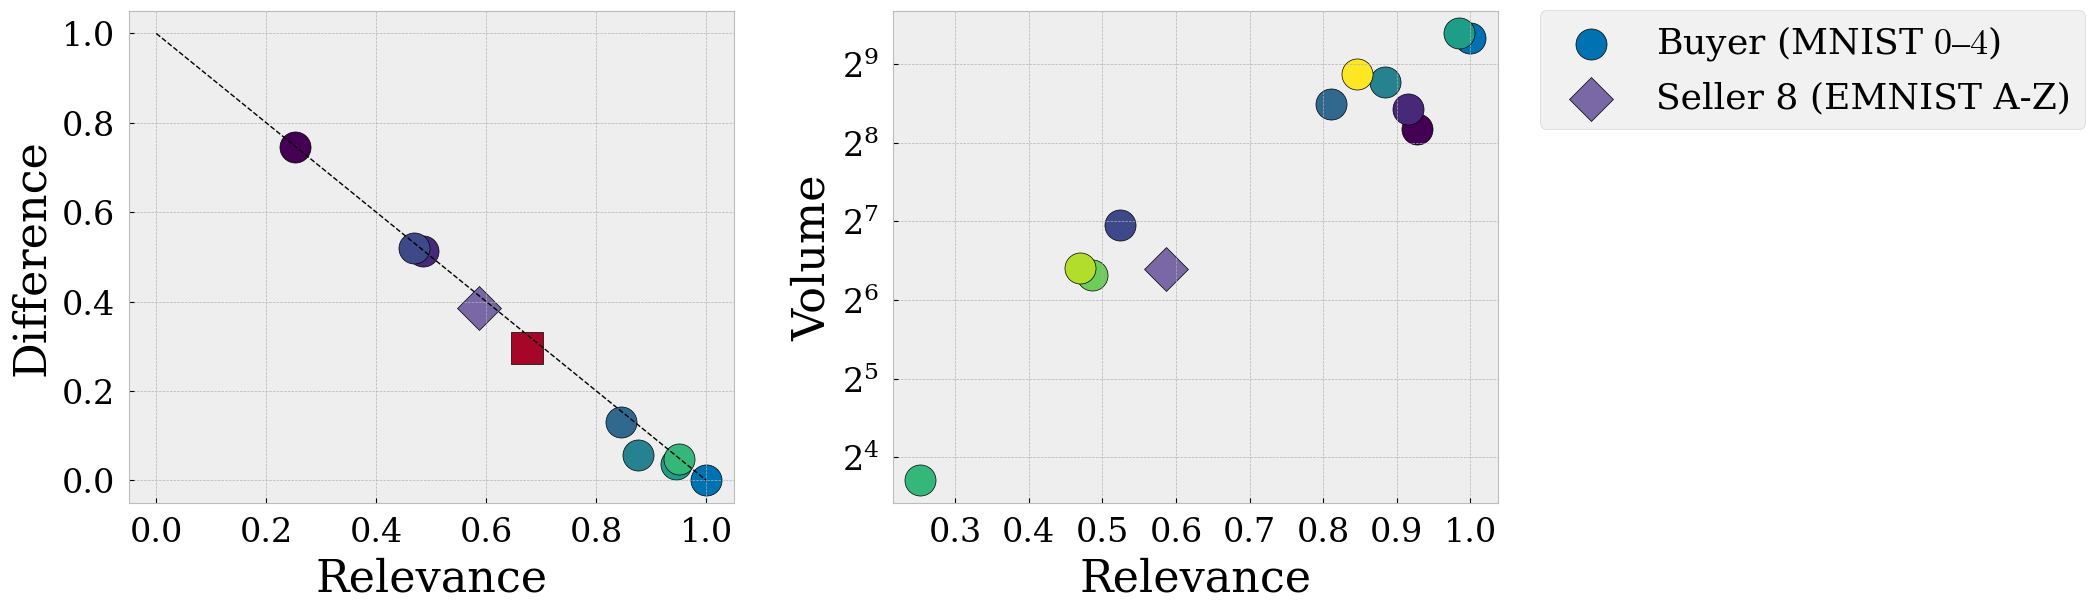

In [183]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 10)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs), c=viridis[6], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s')

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=viridis[0], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller2_vol, c=viridis[1], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller3_vol, c=viridis[2], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller4_vol, c=viridis[3], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller5_vol, c=viridis[4], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller6_vol, c=viridis[5], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[6], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[7], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[8], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[9], edgecolor='k', s=s, label=r'')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs)[0], seller13_vol, c=viridis[6], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 8 (EMNIST A-Z)')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 9 (FashionMNIST)')

# ax[1].set_xlim(0.5, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.04, 1.04))
# plt.savefig(figures / f'mnist-complex.pdf', bbox_inches='tight')
plt.show()

In [180]:
# np.linalg.cond(buyer_components @ seller1_cov.T)

In [181]:
buyer_eig_val.mean(), np.median(buyer_eig_val)

(3.5992274343790727, 0.0009336119610289459)

In [117]:
dup1_proj_cov = pca.transform(dup1_cov)
dup1_vol = get_volume(dup1_proj_cov, omega=omega)

dup2_proj_cov = pca.transform(dup2_cov)
dup2_vol = get_volume(dup2_proj_cov, omega=omega)

dup3_proj_cov = pca.transform(dup3_cov)
dup3_vol = get_volume(dup3_proj_cov, omega=omega)

dup4_proj_cov = pca.transform(dup4_cov)
dup4_vol = get_volume(dup4_proj_cov, omega=omega)

dup5_proj_cov = pca.transform(dup5_cov)
dup5_vol = get_volume(dup5_proj_cov, omega=omega)

mix1_proj_cov = pca.transform(mix1_cov)
mix1_vol = get_volume(mix1_proj_cov, omega=omega)

mix2_proj_cov = pca.transform(mix2_cov)
mix2_vol = get_volume(mix2_proj_cov, omega=omega)

mix3_proj_cov = pca.transform(mix3_cov)
mix3_vol = get_volume(mix3_proj_cov, omega=omega)

mix4_proj_cov = pca.transform(mix4_cov)
mix4_vol = get_volume(mix4_proj_cov, omega=omega)

mix5_proj_cov = pca.transform(mix5_cov)
mix5_vol = get_volume(mix5_proj_cov, omega=omega)

mix6_proj_cov = pca.transform(mix6_cov)
mix6_vol = get_volume(mix6_proj_cov, omega=omega)

mix7_proj_cov = pca.transform(mix7_cov)
mix7_vol = get_volume(mix7_proj_cov, omega=omega)

mix8_proj_cov = pca.transform(mix8_cov)
mix8_vol = get_volume(mix8_proj_cov, omega=omega)

mix9_proj_cov = pca.transform(mix9_cov)
mix9_vol = get_volume(mix9_proj_cov, omega=omega)


In [118]:
def div_rel_func(buyer_eig_vals, buyer_eig_vecs, seller_cov, threshold=1e-2, num_components=2):
    buyer_vals = buyer_eig_vals[:num_components]
    # buyer_vecs = np.abs(buyer_eig_vecs[:num_components])
    buyer_vecs = buyer_eig_vecs[:num_components]
    seller_vals = np.linalg.norm(seller_cov @ buyer_vecs.T, axis=0)

    # Diversity
    div_components = np.abs(buyer_vals - seller_vals) / np.maximum(buyer_vals, seller_vals)

    #  Relevance
    rel_components = np.minimum(buyer_vals, seller_vals) / np.maximum(buyer_vals, seller_vals)
    # print('div', div_components)
    # print('rel', rel_components)

    # filter buyer components by threshold 
    keep_mask = buyer_vals >= threshold

    div = np.prod(np.where(keep_mask, div_components, 1)) ** (1 / keep_mask.sum())
    rel = np.prod(np.where(keep_mask, rel_components, 1)) ** (1 / keep_mask.sum())
    return rel, div #, keep_mask.sum()

In [119]:
def div_rel_func2(buyer_eig_val, buyer_eig_vec, seller_covariance, num_components=None, threshold=1e-1):
    seller_eig_val = np.zeros([len(seller_covariance)])
    Diversity = 1
    Relevance = 1
    count_root = 0
    # div  = []
    # rel = []
    
    # buyer_eig_vec = np.abs(buyer_eig_vec)
    
    for i in range(len(seller_covariance)):
        if num_components is not None and i >= num_components:
            break
        elif buyer_eig_val[i] < threshold:
            continue
            
        count_root += 1
        vec_seller_covariance = np.matmul(seller_covariance, buyer_eig_vec[:, i])
        seller_eig_val[i] = np.abs(np.linalg.norm(vec_seller_covariance))
        # print((seller_eig_val[i], buyer_eig_val[i]))
        Diversity *= np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])
        Relevance *= min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) 
        # div.append(np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]))
        # rel.append(min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) )

    # print(div)
    # print(rel)
    return (Relevance)**(1/count_root), (Diversity)**(1/count_root), count_root

In [120]:

# for num_components in (2, 5, 10, 15, 20):
#     # print(str(num_components).center(40, '-'))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller1_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller2_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller3_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller4_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller5_cov, threshold=threshold, num_components=num_components))
    
#     print(str(num_components).center(40, '-'))
#     print(div_rel_func(buyer_values, buyer_components, seller1_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller2_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller3_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller4_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller5_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller6_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller7_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller8_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller9_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, threshold=threshold, num_components=num_components))
#     if use_features:
#         print(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, threshold=threshold, num_components=num_components))

In [121]:
threshold = 0.1
num_components = 2
# num_components = 3
# num_components = 4
# num_components = 10
kwargs = {'threshold': threshold, 'num_components': num_components}

In [122]:
import matplotlib

In [123]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
# rcParams['font.sans-serif'] = ['Tahoma']

In [124]:
figures = Path('figures')

/tmp/ipykernel_37078/2339956581.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/2339956581.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/2339956581.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/2339956581.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


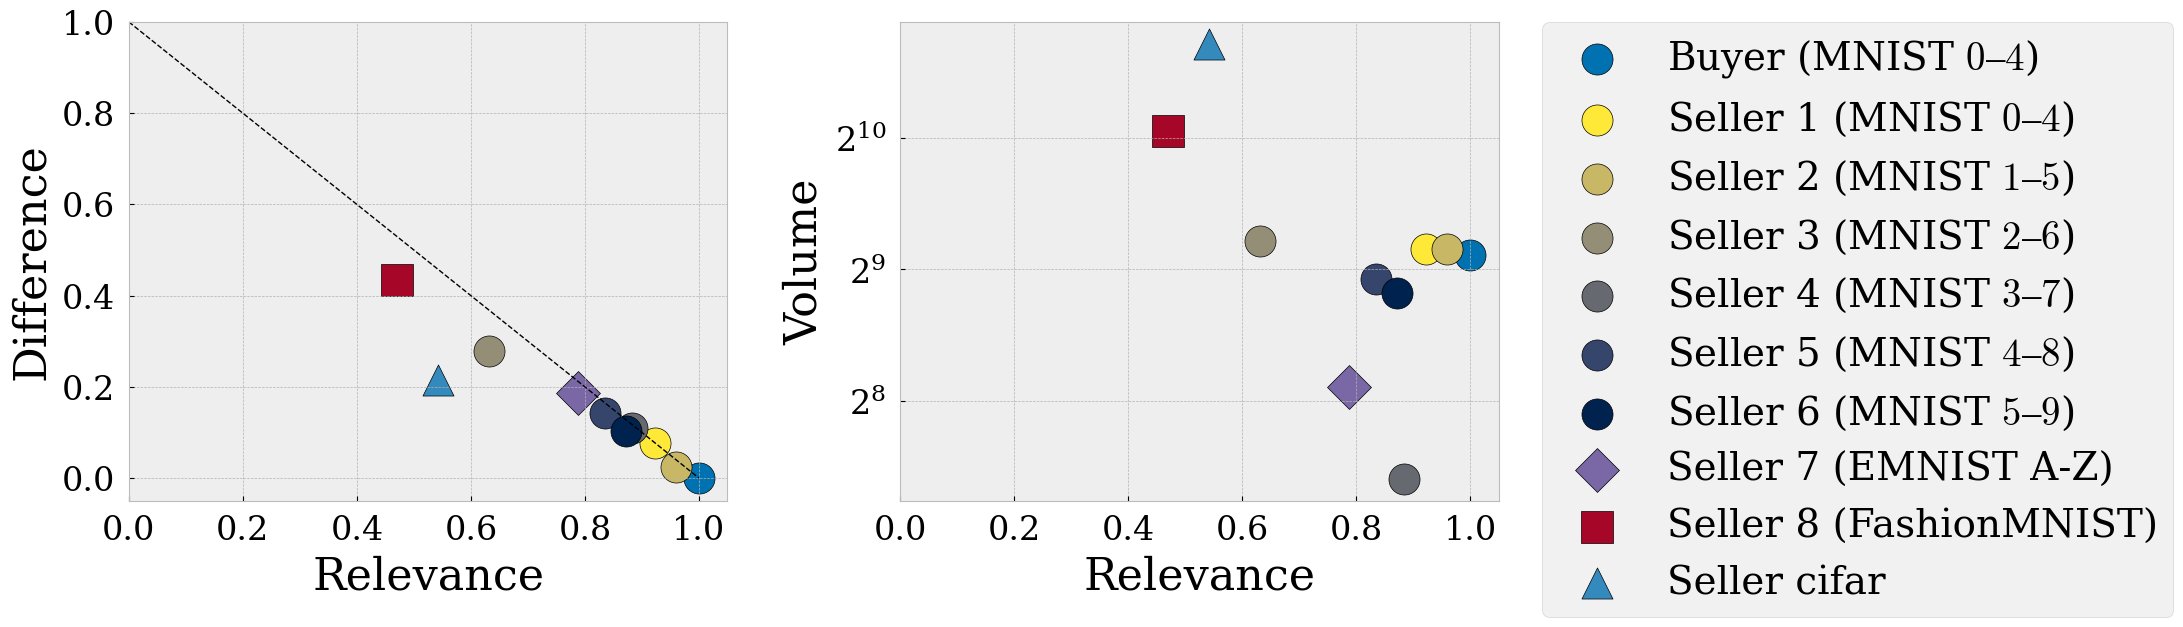

In [125]:
cividis = [np.array([matplotlib.colormaps['cividis'].colors[int(k)]]) for k in np.linspace(255, 0, 6)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=cividis[0], edgecolor='k', s=s, label=r'Seller mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs), c=cividis[1], edgecolor='k', s=s, label=r'Seller mnist $1–5$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs), c=cividis[2], edgecolor='k', s=s, label=r'Seller mnist $2–6$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs), c=cividis[3], edgecolor='k', s=s, label=r'Seller mnist $3–7$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs), c=cividis[4], edgecolor='k', s=s, label=r'Seller mnist $4–8$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=cividis[5], edgecolor='k', s=s, label=r'Seller mnist $5–9$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D', label=r'Seller emnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s', label=r'Seller fashion')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=cividis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller1_vol, c=cividis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $1–5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller2_vol, c=cividis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $2–6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller3_vol, c=cividis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $3–7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller4_vol, c=cividis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $4–8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller5_vol, c=cividis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $5–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 7 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 8 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.04, 1.04))
# plt.savefig(figures / f'mnist-overlap.pdf', bbox_inches='tight')
plt.show()

In [126]:
use_features

True

In [128]:
# s = 500
# plt.figure(figsize=(8, 8))

# plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=viridis[0], marker='P', edgecolor='k', s=s, label=r'Seller mnist $0$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], marker='X', edgecolor='k', s=s, label=r'Seller mnist $5$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s, label=r'Seller mnist $0, 5$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s, label=r'Seller mnist $0, 1, 5, 6$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s, label=r'Seller mnist $0–2, 5-7$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s, label=r'Seller mnist $0-3, 5-8$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s, label=r'Seller mnist $0-9$')

# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), edgecolor='k', s=s, marker='s', label=r'Seller fashion')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), edgecolor='k', s=s, marker='d', label=r'Seller emnist')
# if use_features:
#     plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

# plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
# plt.xlabel('Relevance', fontsize=32)
# plt.ylabel('Diversity', fontsize=32)
# plt.legend(prop={'size': 20}, bbox_to_anchor=(1.70, 1.00))
# plt.savefig(f'mnist-diversity-complex.png', bbox_inches='tight')
# plt.show()

In [83]:

# s = 500
# plt.figure(figsize=(8, 8))
# plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

# plt.scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller6_vol, c=viridis[0], marker='P', edgecolor='k', s=s, label=r'Seller mnist $0$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[0], marker='X', edgecolor='k', s=s, label=r'Seller mnist $5$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[1], edgecolor='k', s=s, label=r'Seller mnist $0, 5$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[2], edgecolor='k', s=s, label=r'Seller mnist $0, 1, 5, 6$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[3], edgecolor='k', s=s, label=r'Seller mnist $0–2, 5-7$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'Seller mnist $0-3, 5-8$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'Seller mnist $0-9$')

# plt.scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, edgecolor='k', s=s, marker='s', label=r'Seller fashion')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, edgecolor='k', s=s, marker='d', label=r'Seller emnist')
# if use_features:
#     plt.scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

# plt.legend(prop={'size': 20}, bbox_to_anchor=(1.70, 1.00))
# plt.yscale('log',base=2) 
# plt.xlim(0, 1.05)
# # plt.ylim(0, 1.05)
# plt.xlabel('Relevance', fontsize=32)
# plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-compex.png', bbox_inches='tight')
# plt.show()


In [84]:
plasma = [matplotlib.colormaps['plasma'].colors[int(k)] for k in np.linspace(255, 0, 6)]

/tmp/ipykernel_37078/286841513.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (100%)')
/tmp/ipykernel_37078/286841513.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s,

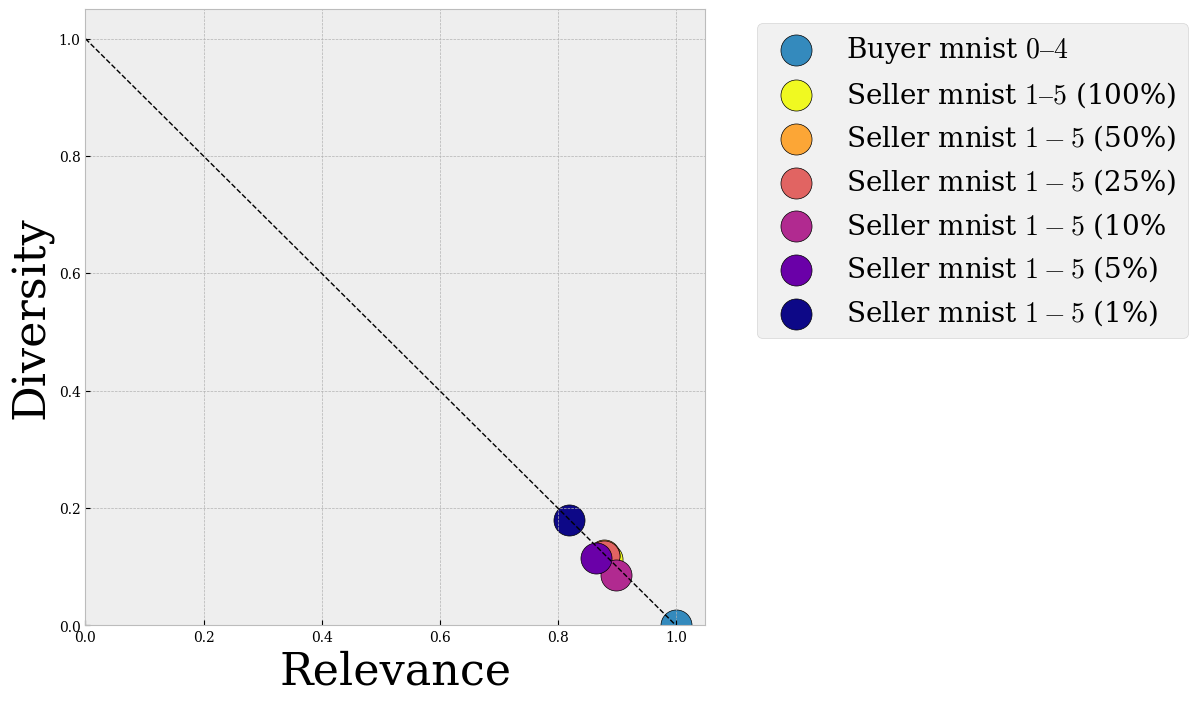

In [85]:
s = 500
plt.figure(figsize=(8, 8))

plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (100%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs), c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (25%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs), c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (10%')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs), c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (5%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup5_cov, **kwargs), c=plasma[5], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (1%)')


plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Diversity', fontsize=32)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.savefig(f'mnist-diversity-dup.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_37078/3635242539.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (100%)')
/tmp/ipykernel_37078/3635242539.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=p

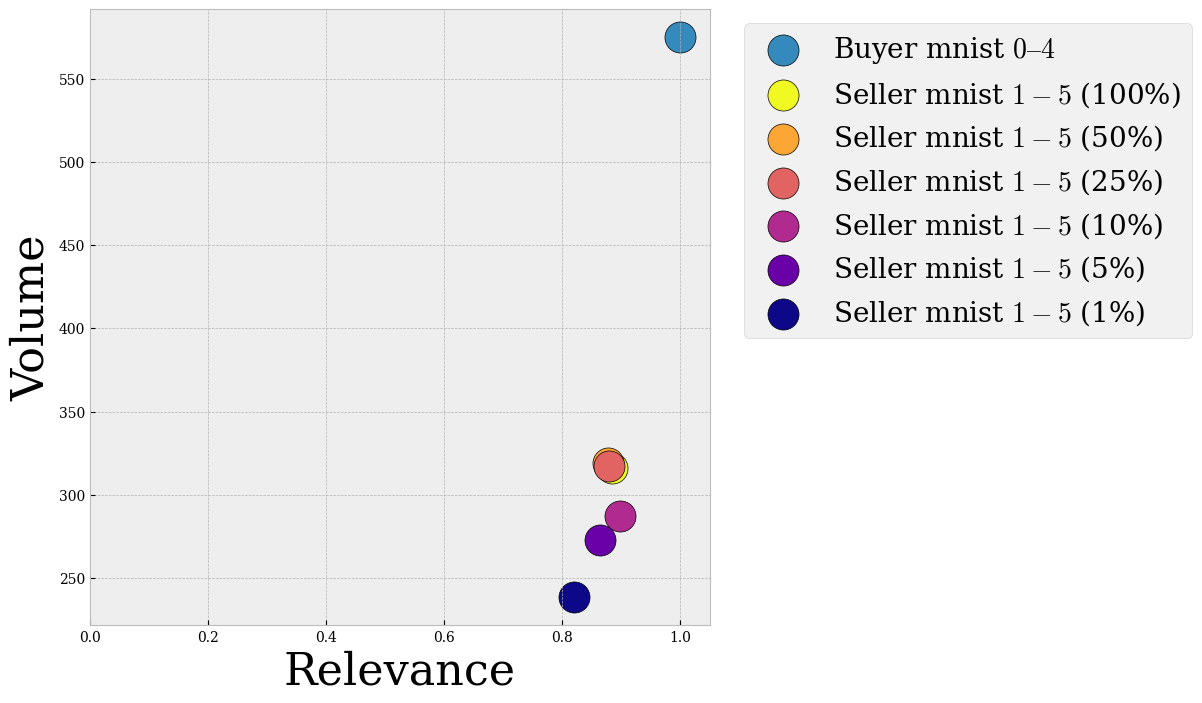

In [86]:
s = 500
plt.figure(figsize=(8, 8))
plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (100%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs)[0], dup2_vol, c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (25%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs)[0], dup3_vol, c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (10%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs)[0], dup4_vol, c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (5%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup5_cov, **kwargs)[0], dup5_vol, c=plasma[5], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (1%)')

plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.yscale('log',base=2) 
plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-dup.png', bbox_inches='tight')
plt.show()


In [87]:
magma = [matplotlib.colormaps['magma'].colors[int(k)] for k in np.linspace(255, 0, 12)]

/tmp/ipykernel_37078/1678871615.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
/tmp/ipykernel_37078/1678871615.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, labe

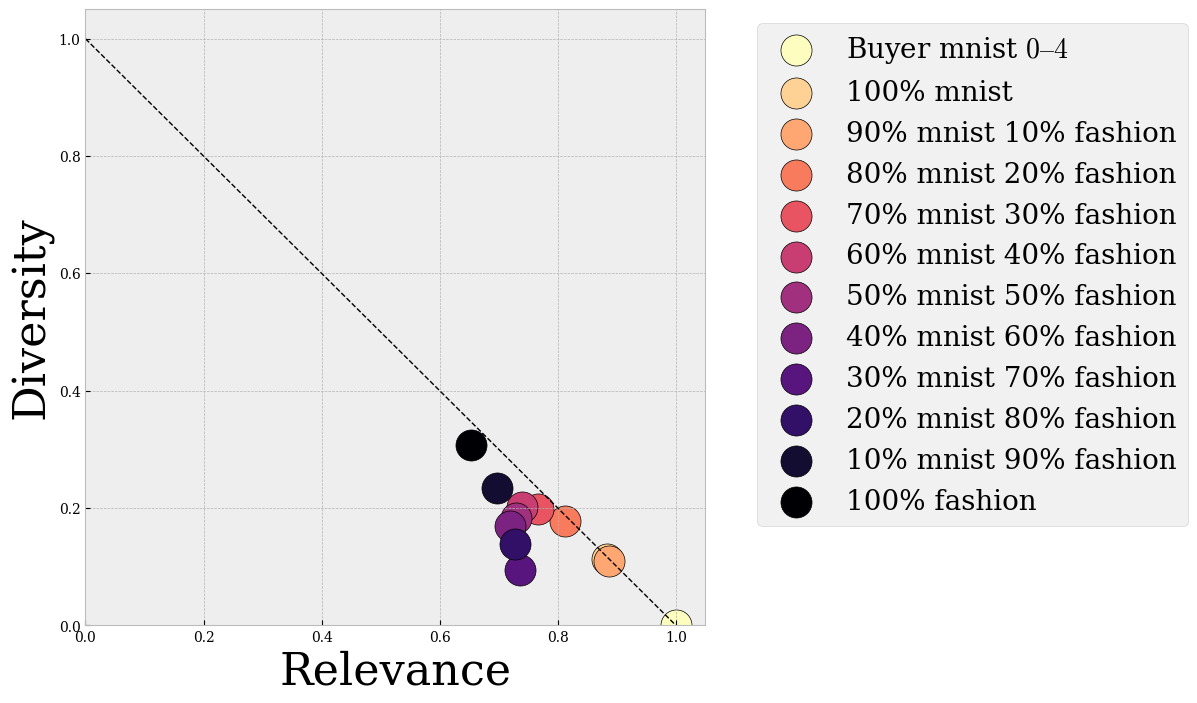

In [90]:

s = 500
plt.figure(figsize=(8, 8))

plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, label=r'100% mnist')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs), c=magma[2], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs), c=magma[3], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs), c=magma[4], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs), c=magma[5], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs), c=magma[6], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs), c=magma[7], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs), c=magma[8], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs), c=magma[9], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs), c=magma[10], edgecolor='k', s=s, label=r'10% mnist 90% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c=magma[11], edgecolor='k', s=s, label=r'100% fashion')


plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Diversity', fontsize=32)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.savefig(f'mnist-diversity-mix.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_37078/2738567140.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
/tmp/ipykernel_37078/2738567140.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma

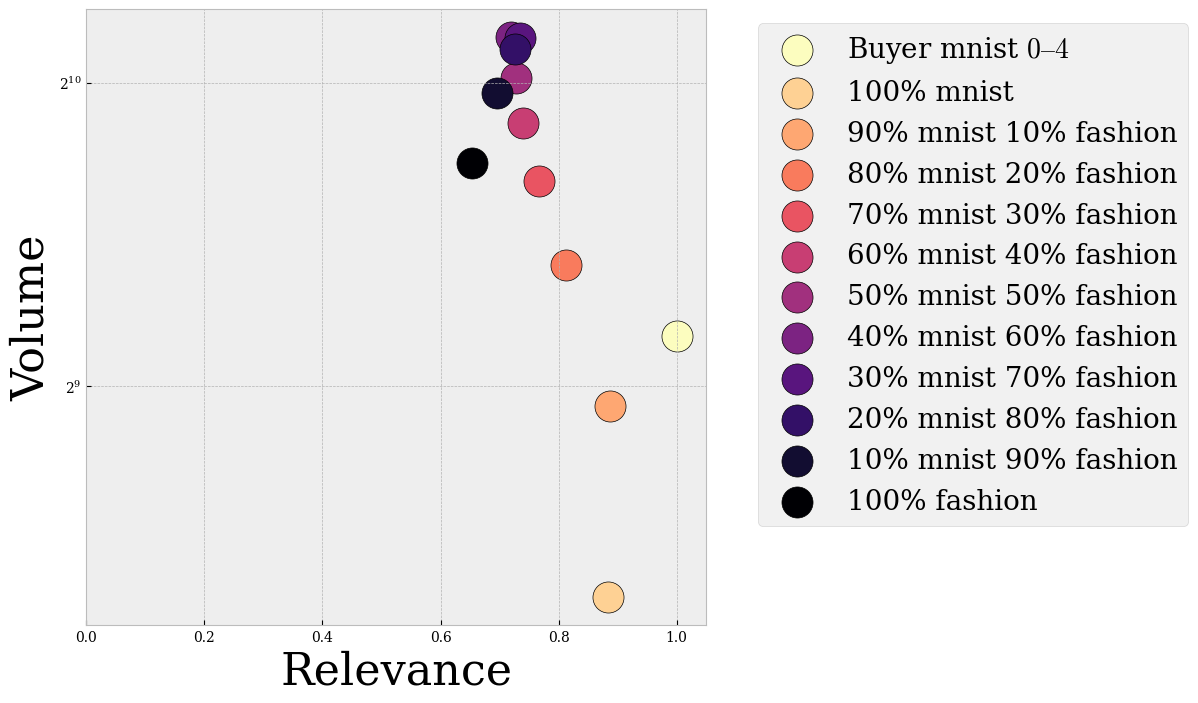

In [91]:
s = 500
plt.figure(figsize=(8, 8))
plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma[1], edgecolor='k', s=s, label=r'100% mnist')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs)[0], mix1_vol, c=magma[2], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs)[0], mix2_vol, c=magma[3], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs)[0], mix3_vol, c=magma[4], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs)[0], mix4_vol, c=magma[5], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs)[0], mix5_vol, c=magma[6], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs)[0], mix6_vol, c=magma[7], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs)[0], mix7_vol, c=magma[8], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs)[0], mix8_vol, c=magma[9], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs)[0], mix9_vol, c=magma[10], edgecolor='k', s=s, label=r'10% mnist 90% fashion')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c=magma[11], edgecolor='k', s=s, label=r'100% fashion')

plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
plt.yscale('log',base=2) 
plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-mix.png', bbox_inches='tight')
plt.show()
